In [1]:
import matplotlib.patches as patches
import xarray as xr
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import geopandas as gpd
import cartopy.feature as cfeature
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import numpy as np
from matplotlib import gridspec
import matplotlib as mpl
from matplotlib.offsetbox import AnnotationBbox, DrawingArea
from matplotlib.patches import Wedge
from shapely.geometry.geo import mapping
from matplotlib.colors import TwoSlopeNorm
from matplotlib import cm
import matplotlib.colors as mcolors
import matplotlib.patches as mpatches
import math

from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.lines import Line2D

def add_unified_colorbar(fig, ax, mesh, label):
    pos = ax.get_position()

    # 颜色条定位参数：在子图底部下方固定距离，宽度为子图宽度70%
    cax_height = 0.01  # 颜色条高度（固定值）
    cax_width = pos.width * 0.7  # 颜色条宽度
    cax_y = pos.y0 - cax_height - 0.035  # 距离子图底部固定距离
    cax_x = pos.x0 + pos.width * 0.15  # 水平居中

    # 创建颜色条坐标轴
    cax = fig.add_axes([cax_x, cax_y, cax_width, cax_height])

    # 添加颜色条
    cbar = fig.colorbar(mesh, cax=cax, orientation='horizontal', extend='both')
    # 在 colorbar 上方左侧添加文字
    cbar.ax.text(0, 1.2, "Decrease", ha='left', va='bottom', fontsize=16, transform=cbar.ax.transAxes)

    # 在 colorbar 上方右侧添加文字
    cbar.ax.text(1, 1.2, "Increase", ha='right', va='bottom', fontsize=16, transform=cbar.ax.transAxes)
    cbar.ax.tick_params(labelsize=14)
    cbar.set_label(label, fontsize=14)

    return cbar

# 绘制矩形地图（输入矩形四角坐标）
def draw_rectange_map(hotpoint, dd, fig=False, ax=None, extent=[-180, 180, -60, 90], linewi=1, lines='-'):
    if fig == False:
        fig = plt.figure(figsize=(12.27, 6.69), dpi=100, facecolor='white')
        ax = fig.add_subplot(1, 1, 1, projection=ccrs.Robinson())
        ax.set_extent(extent, crs=ccrs.PlateCarree())
        ax.add_feature(cfeature.COASTLINE)
        ax.add_feature(cfeature.LAND, facecolor='#FFE9B5')

    ax.plot([hotpoint[dd][2], hotpoint[dd][3]], [hotpoint[dd][1], hotpoint[dd][1]], transform=ccrs.PlateCarree(), linewidth=linewi,
            color='k', ls=lines)
    ax.plot([hotpoint[dd][2], hotpoint[dd][3]], [hotpoint[dd][0], hotpoint[dd][0]], transform=ccrs.PlateCarree(), linewidth=linewi,
            color='k', ls=lines)
    ax.plot([hotpoint[dd][2], hotpoint[dd][2]], [hotpoint[dd][0], hotpoint[dd][1]], transform=ccrs.PlateCarree(), linewidth=linewi,
            color='k', ls=lines)
    ax.plot([hotpoint[dd][3], hotpoint[dd][3]], [hotpoint[dd][0], hotpoint[dd][1]], transform=ccrs.PlateCarree(), linewidth=linewi,
            color='k', ls=lines)

def _parse_hist_fut_classes(da_change):
    """从两位数编码解析历史与未来地类（1..6）。"""
    v = da_change.values
    v = np.array(v, dtype=np.int16)
    hist = v // 10
    fut  = v % 10
    return hist, fut

def _agg_by_hist_class(delta_arr, hist_cls, class_id):
    # 修复：将数据转换为numpy数组并展平
    delta_arr_flat = delta_arr.values.ravel()
    hist_cls_flat = hist_cls.ravel()

    # 对指定历史地类，返回中位数Δ、样本数n、上升占比（Δ>0）
    mask = (hist_cls_flat == class_id) & np.isfinite(delta_arr_flat)
    if mask.sum() == 0:
        return np.nan, 0, np.nan
    vals = delta_arr_flat[mask]
    med  = np.nanmedian(vals)
    n    = vals.size
    up   = float(np.mean(vals > 0))
    return med, n, up

def _col_stats(vals_list):
    # 列级（同一指数）全球Δ的中位数与95%CI，输入为一维数组列表
    out = []
    for arr in vals_list:
        # 修复：展平数组
        arr_flat = arr.values.ravel()
        arr_flat = arr_flat[np.isfinite(arr_flat)]
        if arr_flat.size == 0:
            out.append((np.nan, np.nan, np.nan))
        else:
            out.append((
                float(np.median(arr_flat)),
                float(np.percentile(arr_flat, 2.5)),
                float(np.percentile(arr_flat, 97.5))
            ))
    return out

def _transition_stats(delta_da, lc_change_da):
    """
    delta_da: xarray.DataArray, ΔSensitivity (SSP585 - Historical)
    lc_change_da: xarray.DataArray, LANDCOVER_CHANGE (11..66)
    return: (median_matrix[6,6], count_matrix[6,6])
    """
    delta = np.asarray(delta_da.values)
    lcc   = np.asarray(lc_change_da.values)

    # 只保留两者都有效的像元
    valid = np.isfinite(delta) & np.isfinite(lcc)
    delta = delta[valid]
    lcc   = lcc[valid].astype(np.int16)

    med = np.full((6, 6), np.nan, dtype=np.float64)
    cnt = np.zeros((6, 6), dtype=np.int64)

    # 十位=历史，个位=未来（1..6）
    hist_cls = (lcc // 10)
    futu_cls = (lcc % 10)

    for i in range(1, 7):
        for j in range(1, 7):
            m = (hist_cls == i) & (futu_cls == j)
            if np.any(m):
                vals = delta[m]
                cnt[i-1, j-1] = vals.size
                # 使用中位数稳健统计
                med[i-1, j-1] = np.nanmedian(vals)
    return med, cnt

# ------- 小工具：在给定的轴上画 6×6 热图并叠加圆点数量 -------
def _draw_heatmap(ax, mat, counts, title, vmin, vmax, showY = False, ssp='ssp585'):
    classes = ["Cropland","Forest","Grassland","Urban","Barren","Water"]

    # 背景热图
    norm = TwoSlopeNorm(vmin=vmin, vcenter=0.0, vmax=vmax)
    im = ax.imshow(mat, origin='upper', cmap=cm.get_cmap("BrBG"), norm=norm,
                   extent=(0.5, 6.5, 6.5, 0.5), aspect='equal', interpolation='nearest')

    # 叠加数量（圆点面积按 count 归一化）
    if np.nanmax(counts) > 0:
        xs = np.arange(1, 7)
        ys = np.arange(1, 7)
        X, Y = np.meshgrid(xs, ys)
        s = (counts / np.nanmax(counts))
        s = np.sqrt(s)  # 开平方使大小差异更柔和
        ax.scatter(X.ravel(), Y.ravel(), s=(s.ravel()*800),
                   facecolors='none', edgecolors='#FFFFFF',
                   linewidths=2.0, alpha=0.9, zorder=4)

        ax.scatter(X.ravel(), Y.ravel(), s=(s.ravel()*800),
                   facecolors='none', edgecolors='#1460F3',
                   linewidths=1.2, alpha=0.9, zorder=5)

    # 网格线
    for k in range(1, 7):
        ax.axhline(k+0.5, color='white', lw=0.8, alpha=0.7)
        ax.axvline(k+0.5, color='white', lw=0.8, alpha=0.7)

    # 轴与标签
    ax.set_xticks(np.arange(1, 7))

    ax.set_xticklabels(classes, rotation=35, ha='right', fontsize=16)
    if ssp == 'ssp585':
        ax.set_xlabel("SSP5-8.5 land-cover class", fontsize=16)
    elif ssp == 'ssp370':
        ax.set_xlabel("SSP3-7.0 land-cover class", fontsize=16)
    elif ssp == 'ssp245':
        ax.set_xlabel("SSP2-4.5 land-cover class", fontsize=16)
    elif ssp == 'ssp126':
        ax.set_xlabel("SSP1-2.6 land-cover class", fontsize=16)
    if showY:
        ax.text(-0.1, 1.07, 'a',
            fontweight='bold',
            transform=ax.transAxes,
            fontsize=22,
            va='top', ha='left')
        ax.set_ylabel("Historical land-cover class", fontsize=16)
        ax.set_yticklabels(classes, fontsize=16)
        ax.set_yticks(np.arange(1, 7))
    else:
        ax.set_yticks([])
        ax.set_yticklabels([])
        ax.set_ylabel("")
    ax.set_title(title, fontsize=16)

    return im

def reshape(ds1, ds2):
    """
    对模型数据进行插值，并统一输出
    :param ds1: 需要插值的模型数据
    :param ds2: 基准数据
    :return: 插值后的模型数据
    """
    ds1['lon'] = (ds1['lon'] + 180) % 360 - 180
    ds1 = ds1.sortby('lon')
    ds2['lon'] = (ds2['lon'] + 180) % 360 - 180
    ds2 = ds2.sortby('lon')
    # @roll：
    ds1 = ds1.roll(lon=len(ds1['lon']) // 2, roll_coords='lon')
    ds1 = ds1.interp(lat=ds2.lat, lon=ds2.lon, method='nearest')
    return ds1

def re_prj(ds):
    """
    重新投影
    :param ds: 待处理的netcdf文件
    :return: 处理后的变量
    """
    if 'grid_mapping' in ds.attrs:
        # 如果有，移除这个键
        del ds.attrs['grid_mapping']
    shp = gpd.read_file(r"E:\Drought_And_SOC\001_shape_data_GIS\ne_50m_land.shp")
    ds.rio.set_spatial_dims(x_dim="lon", y_dim="lat", inplace=True)
    ds.rio.write_crs(shp.crs, inplace=True)
    dsre = ds.rio.clip(shp.geometry.apply(mapping), shp.crs, drop=False)
    mask_path = "E:/Drought_And_SOC/Pokhrel_NCC2021_ISIMIP_TWS_reshaped.nc"
    mask = xr.open_dataset(mask_path)['tws_ref'].isel(time=0).load()
    dsre = dsre.interp_like(mask, method='nearest')
    dsre = dsre.where(~np.isnan(mask))
    return dsre

def km_per_deg(lat_deg):
    k_lat = 110.574
    k_lon = 111.320 * math.cos(math.radians(lat_deg))
    return k_lat, k_lon

def wh_km(latmin, latmax, lonmin, lonmax):
    dlat = latmax - latmin
    dlon = lonmax - lonmin
    latc = 0.5*(latmin + latmax)
    k_lat, k_lon = km_per_deg(latc)
    W = abs(dlon) * k_lon
    H = abs(dlat) * k_lat
    return W, H, latc

def pad_extent_both(latmin, latmax, lonmin, lonmax, target_ratio, margin_frac=0.02):
    """
    先做最小必要留白使长宽比达标，再在横/竖两个方向同时
    按 margin_frac 额外扩展（“呼吸边”），确保最大可见度+一致画幅。
    """
    W, H, latc = wh_km(latmin, latmax, lonmin, lonmax)
    r = W/H
    k_lat, k_lon = km_per_deg(latc)
    dlat0 = (latmax - latmin)/2
    dlon0 = (lonmax - lonmin)/2

    if r < target_ratio:
        # 需要更宽
        W_need = target_ratio * H
        dlon_need = (W_need / k_lon) / 2.0
        dlon = max(dlon0, dlon_need)
        dlat = dlat0
    else:
        # 需要更高
        H_need = W / target_ratio
        dlat_need = (H_need / k_lat) / 2.0
        dlat = max(dlat0, dlat_need)
        dlon = dlon0

    # 两向同时加呼吸边
    dlat *= (1 + margin_frac)
    dlon *= (1 + margin_frac)

    latc = 0.5*(latmin + latmax)
    lonc = 0.5*(lonmin + lonmax)
    latmin_p = max(-90.0,  latc - dlat)
    latmax_p = min( 90.0,  latc + dlat)
    lonmin_p = max(-180.0, lonc - dlon)
    lonmax_p = min( 180.0, lonc + dlon)
    return latmin_p, latmax_p, lonmin_p, lonmax_p

landmask = xr.open_dataset("F:/008_Screening_data_CMIP6/Masks/landmask.nc")['mask']
base_proj_path = "E:/Drought_And_SOC/Pokhrel_NCC2021_ISIMIP_TWS_reshaped.nc"
base_proj_ds = xr.open_dataset(base_proj_path)
LANDCOVER_CHANGE = xr.open_dataset(f"E:/Drought_And_SOC/001-1_land_use_data_TIFF/result/ssp585_land_cover_change.nc")['land_cover_change']
LANDCOVER_CHANGE = reshape(LANDCOVER_CHANGE, base_proj_ds)
LANDCOVER_CHANGE = re_prj(LANDCOVER_CHANGE)

# ======== 配色与小工具 ========
INDEX_COLORS = {"SPEI": "#fca525", "SSMI": "#27c5cd", "STI": "#eb4116"}
LC_LABELS = ["Cropland","Forest","Grassland","Urban","Barren","Water"]

def _slice_region(da, bounds):
    """bounds = [lat_min, lat_max, lon_min, lon_max]"""
    return da.sel(lat=slice(bounds[0], bounds[1]), lon=slice(bounds[2], bounds[3]))

def _median_ci(a, q=(2.5, 97.5)):
    """对一维数组 a（可能含 NaN）给出中位数与分位数 CI。"""
    a = np.asarray(a).ravel()
    a = a[np.isfinite(a)]
    if a.size == 0:
        return np.nan, (np.nan, np.nan)
    return float(np.median(a)), (float(np.percentile(a, q[0])), float(np.percentile(a, q[1])))

def _add_three_axes_below(fig, host_ax, map_frac=0.62, dumbbell_frac=0.18, heatmap_frac=0.20, h_gap=0.05, w_gap=0.2):
    """
    在 host_ax 所在网格内重建3个轴：
      - 顶部：map（占整列宽度）
      - 底部：左 db（60% 宽） + 右 hm（40% 宽）
    要求：db 的左边界、hm 的右边界与 map 的左右边界对齐。
    参数：
      map_frac, dumbbell_frac, heatmap_frac 控制竖向高度；gap 既用于上下间距（相对高度），也用于左右间距（相对宽度）。
    返回：
      ax_map, ax_dumbbell, ax_heatmap
    """
    # 拿到原轴位置并移除
    pos = host_ax.get_position()
    fig.canvas.draw_idle()
    host_ax.remove()

    # 尺度
    H, W = pos.height, pos.width
    gapH = h_gap * H           # 竖向间距（map 与底部行之间）
    gapW = w_gap * W           # 底部 db 与 hm 之间的横向间距

    # 竖向高度：顶部 map + 间距 + 底部一行（db/hm 等高）
    h_map = H * map_frac
    h_bottom = H * (dumbbell_frac + heatmap_frac)  # 底部一行的总高度（db 和 hm 等高）

    # 竖向定位：自下而上
    y_bottom = pos.y0
    y_map = y_bottom + h_bottom + gapH

    # 顶部 map：全宽
    ax_map = fig.add_axes([pos.x0, y_map, W, h_map], projection=ccrs.PlateCarree())

    # 底部左右：db 60% + hm 40%，中间 gapW；左右边界与 map 对齐
    db_w = 0.50 * W - gapW / 2.0
    hm_w = 0.50 * W - gapW / 2.0
    x_db = pos.x0
    x_hm = pos.x0 + db_w + gapW

    ax_db = fig.add_axes([x_db, y_bottom, db_w, h_bottom])
    ax_hm = fig.add_axes([x_hm, y_bottom, hm_w, h_bottom])

    return ax_map, ax_db, ax_hm

# ======== 区域面板：哑铃图（历史 vs SSP5-8.5；SOC） ========
def _plot_region_dumbbell(ax_db, bounds, spei_hist, ssmi_hist, sti_hist,
                          spei_fut, ssmi_fut, sti_fut, landmask):
    lm = _slice_region(landmask, bounds)

    dat = {}
    for name, hda, fda in [
        ("SPEI", spei_hist, spei_fut),
        ("SSMI", ssmi_hist, ssmi_fut),
        ("STI",  sti_hist,  sti_fut)
    ]:
        h = _slice_region(hda, bounds).where(lm == 1)
        f = _slice_region(fda, bounds).where(lm == 1)
        med_h, (lo_h, hi_h) = _median_ci(h.values)
        med_f, (lo_f, hi_f) = _median_ci(f.values)
        dat[name] = {"hist": (med_h, lo_h, hi_h), "fut": (med_f, lo_f, hi_f)}

    # 画哑铃（横轴 r，取 [-1,1]，更可比）
    ax_db.axvline(0, color="#999999", lw=1, alpha=0.6, zorder=0)
    y = np.array([3, 2, 1])  # 从上到下：SPEI, SSMI, STI
    names = ["SPEI", "SSMI", "STI"]

    for yi, nm in zip(y, names):
        c = INDEX_COLORS[nm]
        m_h, lo_h, hi_h = dat[nm]["hist"]
        m_f, lo_f, hi_f = dat[nm]["fut"]

        # 连接线
        if np.isfinite(m_h) and np.isfinite(m_f):
            ax_db.hlines(yi, m_h, m_f, color=c, lw=2.2, alpha=0.9, zorder=2)

        # 端点 + 95% CI（以像元分布分位数近似）
        # 历史：空心圆
        if np.isfinite(m_h):
            ax_db.errorbar(m_h, yi, xerr=[[m_h-lo_h],[hi_h-m_h]], fmt="o", ms=5.5,
                           mec=c, mfc="white", mew=1.6, ecolor=c, elinewidth=1.4, capsize=2.2, zorder=3)
        # 未来：实心圆
        if np.isfinite(m_f):
            ax_db.errorbar(m_f, yi, xerr=[[m_f-lo_f],[hi_f-m_f]], fmt="o", ms=6.0,
                           mec=c, mfc=c, mew=1.2, ecolor=c, elinewidth=1.4, capsize=2.2, zorder=3)

    ax_db.set_yticks(y)
    ax_db.set_yticklabels(names, fontsize=13)
    # ax_db.set_xlabel("Partial correlation of SOC", fontsize=11)
    ax_db.set_xlim(-1.0, 1.0)
    # ax_db.set_title("", fontsize=11)
    ax_db.grid(axis='x', color="#dddddd", lw=0.8, alpha=0.7)

# ======== 区域面板：微型热图（6 类 LC × 3 指数 的 Δ） ========
def _plot_region_microheat(ax_hm, bounds, spei_hist, ssmi_hist, sti_hist,
                           spei_fut, ssmi_fut, sti_fut, lc_change, landmask):
    """
    色深= Δr(SSP5-8.5 − Historical) 的中位数；小圆点大小= 像元数 n。
    行：未来（SSP5-8.5）土地覆盖 1..6；列：SPEI/SSMI/STI
    """
    lm = _slice_region(landmask, bounds)
    lcc = _slice_region(lc_change, bounds)
    fut_cls = (lcc.values % 10).astype(np.int16)

    # Δr 网格
    spei_d = (_slice_region(spei_fut, bounds) - _slice_region(spei_hist, bounds)).where(lm == 1).values
    ssmi_d = (_slice_region(ssmi_fut, bounds) - _slice_region(ssmi_hist, bounds)).where(lm == 1).values
    sti_d  = (_slice_region(sti_fut,  bounds) - _slice_region(sti_hist,  bounds)).where(lm == 1).values

    mats = np.full((6, 3), np.nan, dtype=float)
    cnts = np.zeros((6, 3), dtype=int)

    for k in range(1, 7):  # 未来地类
        mk = (fut_cls == k)
        if not np.any(mk):
            continue
        for j, arr in enumerate([spei_d, ssmi_d, sti_d]):  # 0..2
            vals = arr[mk]
            vals = vals[np.isfinite(vals)]
            if vals.size == 0:
                continue
            mats[k-1, j] = np.nanmedian(vals)
            cnts[k-1, j] = vals.size

    # 统一色轴（按区域内 Δ 的 98 分位）
    avals = mats[np.isfinite(mats)]
    vlim = np.nanpercentile(np.abs(avals), 98) if avals.size else 1.0
    norm = TwoSlopeNorm(vmin=-vlim, vcenter=0.0, vmax=vlim)
    im = ax_hm.imshow(mats, origin='upper', cmap=cm.get_cmap("BrBG"), norm=norm,
                      extent=(0.5, 3.5, 6.5, 0.5), aspect='auto', interpolation='nearest', zorder=1)

    # 圆点叠加样本量（相对最大 n）
    if cnts.max() > 0:
        X, Y = np.meshgrid(np.arange(1, 4), np.arange(1, 7))
        s = cnts / cnts.max()
        s = np.sqrt(s)
        ax_hm.scatter(X.ravel(), Y.ravel(), s=(s.ravel()*200),
                   facecolors='none', edgecolors='#FFFFFF',
                   linewidths=1.3, alpha=0.9, zorder=4)

        ax_hm.scatter(X.ravel(), Y.ravel(), s=(s.ravel()*200),
                   facecolors='none', edgecolors='#1460F3',
                   linewidths=0.9, alpha=0.9, zorder=5)

    # 网格线、坐标与标题
    for k in range(1, 7):
        ax_hm.axhline(k+0.5, color='white', lw=0.8, alpha=0.7)
    for k in range(1, 3):
        ax_hm.axvline(k+0.5, color='white', lw=0.8, alpha=0.7)

    ax_hm.set_xticks([1, 2, 3])
    ax_hm.set_xticklabels(["SPEI","SSMI","STI"], fontsize=13)
    ax_hm.set_yticks([1,2,3,4,5,6])
    ax_hm.set_yticklabels(LC_LABELS, fontsize=11)
    # ax_hm.set_xlabel("Index", fontsize=11)
    # ax_hm.set_ylabel("", fontsize=11)
    # ax_hm.set_title("ΔSensitivity by land-cover", fontsize=11)

    # 小色标（仅在热图下方放，避免重复；与面板宽度齐平）
    # cax = ax_hm.inset_axes([0.15, -0.45, 0.7, 0.12])  # 相对 ax_hm 的坐标
    # cb = plt.colorbar(im, cax=cax, orientation='horizontal', extend='both')
    # cb.ax.tick_params(labelsize=10)
    # cb.set_label("ΔSensitivity (SSP5-8.5 − Historical)", fontsize=10)

In [2]:
def plot_extendedfig6a(fig, ax, ssp, var):
    SPEI_SOC_HISTORICAL_SEN = xr.open_dataset(f"F:/009_PreSeasonN_data_CMIP6/{var}/SPEI/NORMALIZE_historical_Max_sensitivity_{var}&SPEI120.nc")['max_correlation']
    SSMI_SOC_HISTORICAL_SEN = xr.open_dataset(f"F:/009_PreSeasonN_data_CMIP6/{var}/SSMI/NORMALIZE_historical_Max_sensitivity_{var}&SSMI120.nc")['max_correlation']
    STI_SOC_HISTORICAL_SEN = xr.open_dataset(f"F:/009_PreSeasonN_data_CMIP6/{var}/STI/NORMALIZE_historical_Max_sensitivity_{var}&STI120.nc")['max_correlation']

    SPEI_SOC_SSP585_SEN = xr.open_dataset(f"F:/009_PreSeasonN_data_CMIP6/{var}/SPEI/NORMALIZE_{ssp}_Max_sensitivity_{var}&SPEI120.nc")['max_correlation']
    SSMI_SOC_SSP585_SEN = xr.open_dataset(f"F:/009_PreSeasonN_data_CMIP6/{var}/SSMI/NORMALIZE_{ssp}_Max_sensitivity_{var}&SSMI120.nc")['max_correlation']
    STI_SOC_SSP585_SEN = xr.open_dataset(f"F:/009_PreSeasonN_data_CMIP6/{var}/STI/NORMALIZE_{ssp}_Max_sensitivity_{var}&STI120.nc")['max_correlation']

    # 计算 ΔSensitivity（SSP585 - Historical），并与LC网格对齐
    SPEI_delta = SPEI_SOC_SSP585_SEN - SPEI_SOC_HISTORICAL_SEN
    SSMI_delta = SSMI_SOC_SSP585_SEN - SSMI_SOC_HISTORICAL_SEN
    STI_delta  = STI_SOC_SSP585_SEN - STI_SOC_HISTORICAL_SEN

    # 6×6 中位数与样本数
    spei_mat, spei_n = _transition_stats(SPEI_delta, LANDCOVER_CHANGE)
    ssmi_mat, ssmi_n = _transition_stats(SSMI_delta, LANDCOVER_CHANGE)
    sti_mat,  sti_n  = _transition_stats(STI_delta,  LANDCOVER_CHANGE)

    # 统一色轴（对三张图用同一范围，基于98分位对称截断）
    all_vals = np.concatenate([spei_mat.ravel(), ssmi_mat.ravel(), sti_mat.ravel()])
    all_vals = all_vals[np.isfinite(all_vals)]
    if all_vals.size == 0:
        vlim = 1.0
    else:
        vlim = np.nanpercentile(np.abs(all_vals), 98)  # 稳健
        if vlim == 0: vlim = np.nanmax(np.abs(all_vals)) or 1.0

    # 在传入的单个 ax 区域内创建 3 个小轴
    pos = ax.get_position()
    fig.canvas.draw_idle()
    ax.remove()

    gap = 0.03 * pos.width  # 轴间间距（相对 figure 坐标）
    w_each = (pos.width - 2*gap)
    w_each /= 3.0
    axes = []
    for i in range(3):
        left = pos.x0 + i*(w_each + gap)
        a = fig.add_axes([left, pos.y0, w_each, pos.height])
        axes.append(a)
    if var == 'rh':
        # 作图
        im1 = _draw_heatmap(axes[0], spei_mat, spei_n, "ΔSensitivity of Rh to SPEI",
                            vmin=-vlim, vmax=vlim, showY=True, ssp=ssp)
        im2 = _draw_heatmap(axes[1], ssmi_mat, ssmi_n, "ΔSensitivity of Rh to SSMI",
                            vmin=-vlim, vmax=vlim, ssp=ssp)
        im3 = _draw_heatmap(axes[2], sti_mat,  sti_n,  "ΔSensitivity of Rh to STI",
                            vmin=-vlim, vmax=vlim, ssp=ssp)
    elif var == 'soc':
        im1 = _draw_heatmap(axes[0], spei_mat, spei_n, "ΔSensitivity of SOC to SPEI",
                            vmin=-vlim, vmax=vlim, showY=True, ssp=ssp)
        im2 = _draw_heatmap(axes[1], ssmi_mat, ssmi_n, "ΔSensitivity of SOC to SSMI",
                            vmin=-vlim, vmax=vlim, ssp=ssp)
        im3 = _draw_heatmap(axes[2], sti_mat,  sti_n,  "ΔSensitivity of SOC to STI",
                            vmin=-vlim, vmax=vlim, ssp=ssp)

    # 共享色标（放在第三张的右侧）
    cbar = fig.colorbar(im3, ax=axes, orientation='vertical', fraction=0.025, pad=0.02, shrink=0.7, )
    cbar.ax.tick_params(labelsize=14)  # 增加这一行来设置颜色条刻度字体大小
    cbar.set_label("ΔSensitivity (unitless)", fontsize=16)  # 修改颜色条标题字体大小

    for a in axes:
        a.tick_params(axis='both', labelsize=14)
        a.set_xlim(0.5, 6.5)
        a.set_ylim(6.5, 0.5)

    return None

In [3]:
def plot_extendedfig6b(fig, ax, ssp, var):
    # 重新在该单元内建立三轴
    ax_map, ax_db, ax_hm = _add_three_axes_below(fig, ax)
    SPEI_SOC_HISTORICAL_SEN = \
    xr.open_dataset(f"F:/009_PreSeasonN_data_CMIP6/{var}/SPEI/NORMALIZE_historical_Max_sensitivity_{var}&SPEI120.nc")[
        'max_correlation']
    SSMI_SOC_HISTORICAL_SEN = \
    xr.open_dataset(f"F:/009_PreSeasonN_data_CMIP6/{var}/SSMI/NORMALIZE_historical_Max_sensitivity_{var}&SSMI120.nc")[
        'max_correlation']
    STI_SOC_HISTORICAL_SEN = \
    xr.open_dataset(f"F:/009_PreSeasonN_data_CMIP6/{var}/STI/NORMALIZE_historical_Max_sensitivity_{var}&STI120.nc")[
        'max_correlation']

    # 读取三个数据集
    SPEI_SOC_SSP585_SEN = \
    xr.open_dataset(f"F:/009_PreSeasonN_data_CMIP6/{var}/SPEI/NORMALIZE_{ssp}_Max_sensitivity_{var}&SPEI120.nc")[
        'max_correlation']
    SSMI_SOC_SSP585_SEN = \
    xr.open_dataset(f"F:/009_PreSeasonN_data_CMIP6/{var}/SSMI/NORMALIZE_{ssp}_Max_sensitivity_{var}&SSMI120.nc")[
        'max_correlation']
    STI_SOC_SSP585_SEN = \
    xr.open_dataset(f"F:/009_PreSeasonN_data_CMIP6/{var}/STI/NORMALIZE_{ssp}_Max_sensitivity_{var}&STI120.nc")[
        'max_correlation']

    NAMS = [18.3, 34.9, -119.9, -78.7]  # 经纬度范围 [min_lat, max_lat, min_lon, max_lon]
    ADJUSTED_REGION = [14.326941783893824, 38.87305821610618, -120.31200000000001, -78.28800000000001]

    # 裁剪到目标区域
    SPEI_clip = SPEI_SOC_SSP585_SEN.sel(lat=slice(NAMS[0], NAMS[1]), lon=slice(NAMS[2], NAMS[3])).where(
        landmask == 1).__abs__()
    SSMI_clip = SSMI_SOC_SSP585_SEN.sel(lat=slice(NAMS[0], NAMS[1]), lon=slice(NAMS[2], NAMS[3])).where(
        landmask == 1).__abs__()
    STI_clip = STI_SOC_SSP585_SEN.sel(lat=slice(NAMS[0], NAMS[1]), lon=slice(NAMS[2], NAMS[3])).where(
        landmask == 1).__abs__()

    # 创建三维数据堆叠
    combined = xr.concat([SPEI_clip, SSMI_clip, STI_clip], dim='variable')

    # 找出最大值及其索引，处理全NaN的情况
    # 创建一个掩码，标记所有三个值都是NaN的位置
    all_nan_mask = np.isnan(SPEI_clip) & np.isnan(SSMI_clip) & np.isnan(STI_clip)

    # 计算最大值索引，忽略NaN
    max_idx = combined.fillna(-9999).argmax(dim='variable')  # 用-9999填充NaN以便计算

    # 对于所有值都是NaN的位置，设置为特殊值（例如3）
    max_idx = xr.where(all_nan_mask, 3, max_idx)

    # 创建自定义颜色映射（SPEI: 红色, SSMI: 绿色, STI: 蓝色, 无数据: 灰色）
    cmap = mcolors.ListedColormap(['#fca525', '#27c5cd', '#eb4116', 'white'])
    norm = mcolors.BoundaryNorm([-0.5, 0.5, 1.5, 2.5, 3.5], cmap.N)

    # ——地图画在 ax_map（把你原来所有 ax→ax_map）
    ax_map.set_extent([ADJUSTED_REGION[2], ADJUSTED_REGION[3], ADJUSTED_REGION[0], ADJUSTED_REGION[1]],
                      crs=ccrs.PlateCarree())
    ax_map.add_feature(cfeature.LAND, facecolor="white", edgecolor="black", linewidth=0.5)
    ax_map.add_feature(cfeature.COASTLINE, linewidth=0.5)
    ax_map.add_feature(cfeature.BORDERS, linestyle=":", linewidth=0.5)
    ax_map.add_patch(mpatches.Rectangle((NAMS[2], NAMS[0]), NAMS[3] - NAMS[2], NAMS[1] - NAMS[0],
                                        fill=False, lw=1.0, ls='--', color='k', transform=ccrs.PlateCarree(),
                                        zorder=10))
    ax_map.pcolormesh(max_idx.lon, max_idx.lat, max_idx, cmap=cmap, norm=norm,
                      transform=ccrs.PlateCarree(), shading='auto')
    ax_map.set_title('Dominant Factor in NAMS Region', fontsize=16, loc='center', pad=2)

    _plot_region_dumbbell(ax_db, NAMS, SPEI_SOC_HISTORICAL_SEN, SSMI_SOC_HISTORICAL_SEN, STI_SOC_HISTORICAL_SEN,
                          SPEI_SOC_SSP585_SEN, SSMI_SOC_SSP585_SEN, STI_SOC_SSP585_SEN, landmask)
    _plot_region_microheat(ax_hm, NAMS, SPEI_SOC_HISTORICAL_SEN, SSMI_SOC_HISTORICAL_SEN, STI_SOC_HISTORICAL_SEN,
                           SPEI_SOC_SSP585_SEN, SSMI_SOC_SSP585_SEN, STI_SOC_SSP585_SEN, LANDCOVER_CHANGE, landmask)

    ax_map.text(
        -0.1, 1.7, "b", fontweight="bold",
        transform=ax.transAxes, fontsize=22, va="top", ha="left",
        bbox=dict(facecolor="white", alpha=0.8, edgecolor="none"),
    )

    return None

In [4]:
def plot_extendedfig6c(fig, ax, ssp, var):
    # 重新在该单元内建立三轴
    ax_map, ax_db, ax_hm = _add_three_axes_below(fig, ax)

    SPEI_SOC_HISTORICAL_SEN = xr.open_dataset(f"F:/009_PreSeasonN_data_CMIP6/{var}/SPEI/NORMALIZE_historical_Max_sensitivity_{var}&SPEI120.nc")['max_correlation']
    SSMI_SOC_HISTORICAL_SEN = xr.open_dataset(f"F:/009_PreSeasonN_data_CMIP6/{var}/SSMI/NORMALIZE_historical_Max_sensitivity_{var}&SSMI120.nc")['max_correlation']
    STI_SOC_HISTORICAL_SEN = xr.open_dataset(f"F:/009_PreSeasonN_data_CMIP6/{var}/STI/NORMALIZE_historical_Max_sensitivity_{var}&STI120.nc")['max_correlation']

    # 读取三个数据集
    SPEI_SOC_SSP585_SEN = xr.open_dataset(f"F:/009_PreSeasonN_data_CMIP6/{var}/SPEI/NORMALIZE_{ssp}_Max_sensitivity_{var}&SPEI120.nc")['max_correlation']
    SSMI_SOC_SSP585_SEN = xr.open_dataset(f"F:/009_PreSeasonN_data_CMIP6/{var}/SSMI/NORMALIZE_{ssp}_Max_sensitivity_{var}&SSMI120.nc")['max_correlation']
    STI_SOC_SSP585_SEN = xr.open_dataset(f"F:/009_PreSeasonN_data_CMIP6/{var}/STI/NORMALIZE_{ssp}_Max_sensitivity_{var}&STI120.nc")['max_correlation']

    AMZ_SE = [-24.1, 1.5, -60.5, -34.5]  # 经纬度范围 [min_lat, max_lat, min_lon, max_lon]
    ADJUSTED_REGION = [-24.356, 1.7560000000000002, -69.68961880527392, -25.31038119472608]

    # 裁剪到目标区域
    SPEI_clip = SPEI_SOC_SSP585_SEN.sel(lat=slice(AMZ_SE[0], AMZ_SE[1]), lon=slice(AMZ_SE[2], AMZ_SE[3])).where(landmask == 1).__abs__()
    SSMI_clip = SSMI_SOC_SSP585_SEN.sel(lat=slice(AMZ_SE[0], AMZ_SE[1]), lon=slice(AMZ_SE[2], AMZ_SE[3])).where(landmask == 1).__abs__()
    STI_clip = STI_SOC_SSP585_SEN.sel(lat=slice(AMZ_SE[0], AMZ_SE[1]), lon=slice(AMZ_SE[2], AMZ_SE[3])).where(landmask == 1).__abs__()

    # 创建三维数据堆叠
    combined = xr.concat([SPEI_clip, SSMI_clip, STI_clip], dim='variable')

    # 找出最大值及其索引，处理全NaN的情况
    # 创建一个掩码，标记所有三个值都是NaN的位置
    all_nan_mask = np.isnan(SPEI_clip) & np.isnan(SSMI_clip) & np.isnan(STI_clip)

    # 计算最大值索引，忽略NaN
    max_idx = combined.fillna(-9999).argmax(dim='variable')  # 用-9999填充NaN以便计算

    # 对于所有值都是NaN的位置，设置为特殊值（例如3）
    max_idx = xr.where(all_nan_mask, 3, max_idx)

    # 创建自定义颜色映射（SPEI: 红色, SSMI: 绿色, STI: 蓝色, 无数据: 灰色）
    cmap = mcolors.ListedColormap(['#fca525', '#27c5cd', '#eb4116', 'white'])
    norm = mcolors.BoundaryNorm([-0.5, 0.5, 1.5, 2.5, 3.5], cmap.N)

    # 设置地图范围和特征
    # ——地图画在 ax_map（把你原来所有 ax→ax_map）
    ax_map.set_extent([ADJUSTED_REGION[2], ADJUSTED_REGION[3], ADJUSTED_REGION[0], ADJUSTED_REGION[1]], crs=ccrs.PlateCarree())
    ax_map.add_feature(cfeature.LAND, facecolor="white", edgecolor="black", linewidth=0.5)
    ax_map.add_feature(cfeature.COASTLINE, linewidth=0.5)
    ax_map.add_feature(cfeature.BORDERS, linestyle=":", linewidth=0.5)
    ax_map.add_patch(mpatches.Rectangle((AMZ_SE[2], AMZ_SE[0]), AMZ_SE[3]-AMZ_SE[2], AMZ_SE[1]-AMZ_SE[0],
                                        fill=False, lw=1.0, ls='--', color='k', transform=ccrs.PlateCarree(), zorder=10))
    ax_map.pcolormesh(max_idx.lon, max_idx.lat, max_idx, cmap=cmap, norm=norm,
                      transform=ccrs.PlateCarree(), shading='auto')
    ax_map.set_title('Dominant Factor in AMZ-SE Region', fontsize=16, loc='center', pad=2)

    _plot_region_dumbbell(ax_db, AMZ_SE, SPEI_SOC_HISTORICAL_SEN, SSMI_SOC_HISTORICAL_SEN, STI_SOC_HISTORICAL_SEN, SPEI_SOC_SSP585_SEN, SSMI_SOC_SSP585_SEN, STI_SOC_SSP585_SEN, landmask)
    _plot_region_microheat(ax_hm, AMZ_SE, SPEI_SOC_HISTORICAL_SEN, SSMI_SOC_HISTORICAL_SEN, STI_SOC_HISTORICAL_SEN, SPEI_SOC_SSP585_SEN, SSMI_SOC_SSP585_SEN, STI_SOC_SSP585_SEN, LANDCOVER_CHANGE, landmask)

    ax_map.text(
        -0.1, 1.7, "c", fontweight="bold",
        transform=ax.transAxes, fontsize=22, va="top", ha="left",
        bbox=dict(facecolor="white", alpha=0.8, edgecolor="none"),
    )

    return None

In [5]:
def plot_extendedfig6d(fig, ax, ssp, var):
    # 重新在该单元内建立三轴
    ax_map, ax_db, ax_hm = _add_three_axes_below(fig, ax)

    SPEI_SOC_HISTORICAL_SEN = xr.open_dataset(f"F:/009_PreSeasonN_data_CMIP6/{var}/SPEI/NORMALIZE_historical_Max_sensitivity_{var}&SPEI120.nc")['max_correlation']
    SSMI_SOC_HISTORICAL_SEN = xr.open_dataset(f"F:/009_PreSeasonN_data_CMIP6/{var}/SSMI/NORMALIZE_historical_Max_sensitivity_{var}&SSMI120.nc")['max_correlation']
    STI_SOC_HISTORICAL_SEN = xr.open_dataset(f"F:/009_PreSeasonN_data_CMIP6/{var}/STI/NORMALIZE_historical_Max_sensitivity_{var}&STI120.nc")['max_correlation']

    # 读取三个数据集
    SPEI_SOC_SSP585_SEN = xr.open_dataset(f"F:/009_PreSeasonN_data_CMIP6/{var}/SPEI/NORMALIZE_{ssp}_Max_sensitivity_{var}&SPEI120.nc")['max_correlation']
    SSMI_SOC_SSP585_SEN = xr.open_dataset(f"F:/009_PreSeasonN_data_CMIP6/{var}/SSMI/NORMALIZE_{ssp}_Max_sensitivity_{var}&SSMI120.nc")['max_correlation']
    STI_SOC_SSP585_SEN = xr.open_dataset(f"F:/009_PreSeasonN_data_CMIP6/{var}/STI/NORMALIZE_{ssp}_Max_sensitivity_{var}&STI120.nc")['max_correlation']

    MED = [35.2, 56.1, -12.5, 70.3]  # 经纬度范围 [min_lat, max_lat, min_lon, max_lon]
    ADJUSTED_REGION = [20.938138901172, 70.361861098828015, -13.328000000000003, 71.128]

    # 裁剪到目标区域
    SPEI_clip = SPEI_SOC_SSP585_SEN.sel(lat=slice(MED[0], MED[1]), lon=slice(MED[2], MED[3])).where(landmask == 1).__abs__()
    SSMI_clip = SSMI_SOC_SSP585_SEN.sel(lat=slice(MED[0], MED[1]), lon=slice(MED[2], MED[3])).where(landmask == 1).__abs__()
    STI_clip = STI_SOC_SSP585_SEN.sel(lat=slice(MED[0], MED[1]), lon=slice(MED[2], MED[3])).where(landmask == 1).__abs__()

    # 创建三维数据堆叠
    combined = xr.concat([SPEI_clip, SSMI_clip, STI_clip], dim='variable')

    # 找出最大值及其索引，处理全NaN的情况
    # 创建一个掩码，标记所有三个值都是NaN的位置
    all_nan_mask = np.isnan(SPEI_clip) & np.isnan(SSMI_clip) & np.isnan(STI_clip)

    # 计算最大值索引，忽略NaN
    max_idx = combined.fillna(-9999).argmax(dim='variable')  # 用-9999填充NaN以便计算

    # 对于所有值都是NaN的位置，设置为特殊值（例如3）
    max_idx = xr.where(all_nan_mask, 3, max_idx)

    # 创建自定义颜色映射（SPEI: 红色, SSMI: 绿色, STI: 蓝色, 无数据: 灰色）
    cmap = mcolors.ListedColormap(['#fca525', '#27c5cd', '#eb4116', 'white'])
    norm = mcolors.BoundaryNorm([-0.5, 0.5, 1.5, 2.5, 3.5], cmap.N)

    # 设置地图范围和特征
    # ——地图画在 ax_map（把你原来所有 ax→ax_map）
    ax_map.set_extent([ADJUSTED_REGION[2], ADJUSTED_REGION[3], ADJUSTED_REGION[0], ADJUSTED_REGION[1]], crs=ccrs.PlateCarree())
    ax_map.add_feature(cfeature.LAND, facecolor="white", edgecolor="black", linewidth=0.5)
    ax_map.add_feature(cfeature.COASTLINE, linewidth=0.5)
    ax_map.add_feature(cfeature.BORDERS, linestyle=":", linewidth=0.5)
    ax_map.add_patch(mpatches.Rectangle((MED[2], MED[0]), MED[3]-MED[2], MED[1]-MED[0],
                                        fill=False, lw=1.0, ls='--', color='k', transform=ccrs.PlateCarree(), zorder=10))
    ax_map.pcolormesh(max_idx.lon, max_idx.lat, max_idx, cmap=cmap, norm=norm,
                      transform=ccrs.PlateCarree(), shading='auto')
    ax_map.set_title('Dominant Factor in MED Region', fontsize=16, loc='center', pad=2)

    _plot_region_dumbbell(ax_db, MED, SPEI_SOC_HISTORICAL_SEN, SSMI_SOC_HISTORICAL_SEN, STI_SOC_HISTORICAL_SEN, SPEI_SOC_SSP585_SEN, SSMI_SOC_SSP585_SEN, STI_SOC_SSP585_SEN, landmask)
    _plot_region_microheat(ax_hm, MED, SPEI_SOC_HISTORICAL_SEN, SSMI_SOC_HISTORICAL_SEN, STI_SOC_HISTORICAL_SEN, SPEI_SOC_SSP585_SEN, SSMI_SOC_SSP585_SEN, STI_SOC_SSP585_SEN, LANDCOVER_CHANGE, landmask)

    ax_map.text(
        -0.1, 1.7, "d", fontweight="bold",
        transform=ax.transAxes, fontsize=22, va="top", ha="left",
        bbox=dict(facecolor="white", alpha=0.8, edgecolor="none"),
    )

    return None

In [6]:
def plot_extendedfig6e(fig, ax, ssp, var):
    # 重新在该单元内建立三轴
    ax_map, ax_db, ax_hm = _add_three_axes_below(fig, ax)
    SPEI_SOC_HISTORICAL_SEN = xr.open_dataset(f"F:/009_PreSeasonN_data_CMIP6/{var}/SPEI/NORMALIZE_historical_Max_sensitivity_{var}&SPEI120.nc")['max_correlation']
    SSMI_SOC_HISTORICAL_SEN = xr.open_dataset(f"F:/009_PreSeasonN_data_CMIP6/{var}/SSMI/NORMALIZE_historical_Max_sensitivity_{var}&SSMI120.nc")['max_correlation']
    STI_SOC_HISTORICAL_SEN = xr.open_dataset(f"F:/009_PreSeasonN_data_CMIP6/{var}/STI/NORMALIZE_historical_Max_sensitivity_{var}&STI120.nc")['max_correlation']

    # 读取三个数据集
    SPEI_SOC_SSP585_SEN = xr.open_dataset(f"F:/009_PreSeasonN_data_CMIP6/{var}/SPEI/NORMALIZE_{ssp}_Max_sensitivity_{var}&SPEI120.nc")['max_correlation']
    SSMI_SOC_SSP585_SEN = xr.open_dataset(f"F:/009_PreSeasonN_data_CMIP6/{var}/SSMI/NORMALIZE_{ssp}_Max_sensitivity_{var}&SSMI120.nc")['max_correlation']
    STI_SOC_SSP585_SEN = xr.open_dataset(f"F:/009_PreSeasonN_data_CMIP6/{var}/STI/NORMALIZE_{ssp}_Max_sensitivity_{var}&STI120.nc")['max_correlation']

    S_AF = [-35.0, -12.8, 9.7, 50.6]  # 经纬度范围 [min_lat, max_lat, min_lon, max_lon]
    ADJUSTED_REGION = [-35.34253503594309, -12.45746496405691, 9.290999999999997, 51.009]

    # 裁剪到目标区域
    SPEI_clip = SPEI_SOC_SSP585_SEN.sel(lat=slice(S_AF[0], S_AF[1]), lon=slice(S_AF[2], S_AF[3])).where(landmask == 1).__abs__()
    SSMI_clip = SSMI_SOC_SSP585_SEN.sel(lat=slice(S_AF[0], S_AF[1]), lon=slice(S_AF[2], S_AF[3])).where(landmask == 1).__abs__()
    STI_clip = STI_SOC_SSP585_SEN.sel(lat=slice(S_AF[0], S_AF[1]), lon=slice(S_AF[2], S_AF[3])).where(landmask == 1).__abs__()

    # 创建三维数据堆叠
    combined = xr.concat([SPEI_clip, SSMI_clip, STI_clip], dim='variable')

    # 找出最大值及其索引，处理全NaN的情况
    # 创建一个掩码，标记所有三个值都是NaN的位置
    all_nan_mask = np.isnan(SPEI_clip) & np.isnan(SSMI_clip) & np.isnan(STI_clip)

    # 计算最大值索引，忽略NaN
    max_idx = combined.fillna(-9999).argmax(dim='variable')  # 用-9999填充NaN以便计算

    # 对于所有值都是NaN的位置，设置为特殊值（例如3）
    max_idx = xr.where(all_nan_mask, 3, max_idx)

    # 创建自定义颜色映射（SPEI: 红色, SSMI: 绿色, STI: 蓝色, 无数据: 灰色）
    cmap = mcolors.ListedColormap(['#fca525', '#27c5cd', '#eb4116', 'white'])
    norm = mcolors.BoundaryNorm([-0.5, 0.5, 1.5, 2.5, 3.5], cmap.N)

    # 设置地图范围和特征
    # ——地图画在 ax_map（把你原来所有 ax→ax_map）
    ax_map.set_extent([ADJUSTED_REGION[2], ADJUSTED_REGION[3], ADJUSTED_REGION[0], ADJUSTED_REGION[1]], crs=ccrs.PlateCarree())
    ax_map.add_feature(cfeature.LAND, facecolor="white", edgecolor="black", linewidth=0.5)
    ax_map.add_feature(cfeature.COASTLINE, linewidth=0.5)
    ax_map.add_feature(cfeature.BORDERS, linestyle=":", linewidth=0.5)
    ax_map.add_patch(mpatches.Rectangle((S_AF[2], S_AF[0]), S_AF[3]-S_AF[2], S_AF[1]-S_AF[0],
                                        fill=False, lw=1.0, ls='--', color='k', transform=ccrs.PlateCarree(), zorder=10))
    ax_map.pcolormesh(max_idx.lon, max_idx.lat, max_idx, cmap=cmap, norm=norm,
                      transform=ccrs.PlateCarree(), shading='auto')
    ax_map.set_title('Dominant Factor in S-AF Region', fontsize=16, loc='center', pad=2)

    _plot_region_dumbbell(ax_db, S_AF, SPEI_SOC_HISTORICAL_SEN, SSMI_SOC_HISTORICAL_SEN, STI_SOC_HISTORICAL_SEN, SPEI_SOC_SSP585_SEN, SSMI_SOC_SSP585_SEN, STI_SOC_SSP585_SEN, landmask)
    _plot_region_microheat(ax_hm, S_AF, SPEI_SOC_HISTORICAL_SEN, SSMI_SOC_HISTORICAL_SEN, STI_SOC_HISTORICAL_SEN, SPEI_SOC_SSP585_SEN, SSMI_SOC_SSP585_SEN, STI_SOC_SSP585_SEN, LANDCOVER_CHANGE, landmask)

    ax_map.text(
        -0.1, 1.7, "e", fontweight="bold",
        transform=ax.transAxes, fontsize=22, va="top", ha="left",
        bbox=dict(facecolor="white", alpha=0.8, edgecolor="none"),
    )
    return None

In [7]:
def plot_extendedfig6f(fig, ax, ssp, var):
    # 重新在该单元内建立三轴
    ax_map, ax_db, ax_hm = _add_three_axes_below(fig, ax)
    SPEI_SOC_HISTORICAL_SEN = xr.open_dataset(f"F:/009_PreSeasonN_data_CMIP6/{var}/SPEI/NORMALIZE_historical_Max_sensitivity_{var}&SPEI120.nc")['max_correlation']
    SSMI_SOC_HISTORICAL_SEN = xr.open_dataset(f"F:/009_PreSeasonN_data_CMIP6/{var}/SSMI/NORMALIZE_historical_Max_sensitivity_{var}&SSMI120.nc")['max_correlation']
    STI_SOC_HISTORICAL_SEN = xr.open_dataset(f"F:/009_PreSeasonN_data_CMIP6/{var}/STI/NORMALIZE_historical_Max_sensitivity_{var}&STI120.nc")['max_correlation']

    # 读取三个数据集
    SPEI_SOC_SSP585_SEN = xr.open_dataset(f"F:/009_PreSeasonN_data_CMIP6/{var}/SPEI/NORMALIZE_{ssp}_Max_sensitivity_{var}&SPEI120.nc")['max_correlation']
    SSMI_SOC_SSP585_SEN = xr.open_dataset(f"F:/009_PreSeasonN_data_CMIP6/{var}/SSMI/NORMALIZE_{ssp}_Max_sensitivity_{var}&SSMI120.nc")['max_correlation']
    STI_SOC_SSP585_SEN = xr.open_dataset(f"F:/009_PreSeasonN_data_CMIP6/{var}/STI/NORMALIZE_{ssp}_Max_sensitivity_{var}&STI120.nc")['max_correlation']

    SE_CHN = [21.0, 34.0, 99.4, 123.1]  # 经纬度范围 [min_lat, max_lat, min_lon, max_lon]
    ADJUSTED_REGION = [20.77, 34.23, 98.79273550596503, 123.70726449403497]

    # 裁剪到目标区域
    SPEI_clip = SPEI_SOC_SSP585_SEN.sel(lat=slice(SE_CHN[0], SE_CHN[1]), lon=slice(SE_CHN[2], SE_CHN[3])).where(landmask == 1).__abs__()
    SSMI_clip = SSMI_SOC_SSP585_SEN.sel(lat=slice(SE_CHN[0], SE_CHN[1]), lon=slice(SE_CHN[2], SE_CHN[3])).where(landmask == 1).__abs__()
    STI_clip = STI_SOC_SSP585_SEN.sel(lat=slice(SE_CHN[0], SE_CHN[1]), lon=slice(SE_CHN[2], SE_CHN[3])).where(landmask == 1).__abs__()

    # 创建三维数据堆叠
    combined = xr.concat([SPEI_clip, SSMI_clip, STI_clip], dim='variable')

    # 找出最大值及其索引，处理全NaN的情况
    # 创建一个掩码，标记所有三个值都是NaN的位置
    all_nan_mask = np.isnan(SPEI_clip) & np.isnan(SSMI_clip) & np.isnan(STI_clip)

    # 计算最大值索引，忽略NaN
    max_idx = combined.fillna(-9999).argmax(dim='variable')  # 用-9999填充NaN以便计算

    # 对于所有值都是NaN的位置，设置为特殊值（例如3）
    max_idx = xr.where(all_nan_mask, 3, max_idx)

    # 创建自定义颜色映射（SPEI: 红色, SSMI: 绿色, STI: 蓝色, 无数据: 灰色）
    cmap = mcolors.ListedColormap(['#fca525', '#27c5cd', '#eb4116', 'white'])
    norm = mcolors.BoundaryNorm([-0.5, 0.5, 1.5, 2.5, 3.5], cmap.N)

    # 设置地图范围和特征
    # ——地图画在 ax_map（把你原来所有 ax→ax_map）
    ax_map.set_extent([ADJUSTED_REGION[2], ADJUSTED_REGION[3], ADJUSTED_REGION[0], ADJUSTED_REGION[1]], crs=ccrs.PlateCarree())
    ax_map.add_feature(cfeature.LAND, facecolor="white", edgecolor="black", linewidth=0.5)
    ax_map.add_feature(cfeature.COASTLINE, linewidth=0.5)
    ax_map.add_feature(cfeature.BORDERS, linestyle=":", linewidth=0.5)
    ax_map.add_patch(mpatches.Rectangle((SE_CHN[2], SE_CHN[0]), SE_CHN[3]-SE_CHN[2], SE_CHN[1]-SE_CHN[0],
                                        fill=False, lw=1.0, ls='--', color='k', transform=ccrs.PlateCarree(), zorder=10))
    ax_map.pcolormesh(max_idx.lon, max_idx.lat, max_idx, cmap=cmap, norm=norm,
                      transform=ccrs.PlateCarree(), shading='auto')
    ax_map.set_title('Dominant Factor in SE-CHN Region', fontsize=16, loc='center', pad=2)

    _plot_region_dumbbell(ax_db, SE_CHN, SPEI_SOC_HISTORICAL_SEN, SSMI_SOC_HISTORICAL_SEN, STI_SOC_HISTORICAL_SEN, SPEI_SOC_SSP585_SEN, SSMI_SOC_SSP585_SEN, STI_SOC_SSP585_SEN, landmask)
    _plot_region_microheat(ax_hm, SE_CHN, SPEI_SOC_HISTORICAL_SEN, SSMI_SOC_HISTORICAL_SEN, STI_SOC_HISTORICAL_SEN, SPEI_SOC_SSP585_SEN, SSMI_SOC_SSP585_SEN, STI_SOC_SSP585_SEN, LANDCOVER_CHANGE, landmask)

    ax_map.text(
        -0.1, 1.7, "f", fontweight="bold",
        transform=ax.transAxes, fontsize=22, va="top", ha="left",
        bbox=dict(facecolor="white", alpha=0.8, edgecolor="none"),
    )
    return None

In [8]:
def plot_extendedfig6g(fig, ax, ssp, var):
    # 重新在该单元内建立三轴
    ax_map, ax_db, ax_hm = _add_three_axes_below(fig, ax)
    SPEI_SOC_HISTORICAL_SEN = xr.open_dataset(f"F:/009_PreSeasonN_data_CMIP6/{var}/SPEI/NORMALIZE_historical_Max_sensitivity_{var}&SPEI120.nc")['max_correlation']
    SSMI_SOC_HISTORICAL_SEN = xr.open_dataset(f"F:/009_PreSeasonN_data_CMIP6/{var}/SSMI/NORMALIZE_historical_Max_sensitivity_{var}&SSMI120.nc")['max_correlation']
    STI_SOC_HISTORICAL_SEN = xr.open_dataset(f"F:/009_PreSeasonN_data_CMIP6/{var}/STI/NORMALIZE_historical_Max_sensitivity_{var}&STI120.nc")['max_correlation']

    # 读取三个数据集
    SPEI_SOC_SSP585_SEN = xr.open_dataset(f"F:/009_PreSeasonN_data_CMIP6/{var}/SPEI/NORMALIZE_{ssp}_Max_sensitivity_{var}&SPEI120.nc")['max_correlation']
    SSMI_SOC_SSP585_SEN = xr.open_dataset(f"F:/009_PreSeasonN_data_CMIP6/{var}/SSMI/NORMALIZE_{ssp}_Max_sensitivity_{var}&SSMI120.nc")['max_correlation']
    STI_SOC_SSP585_SEN = xr.open_dataset(f"F:/009_PreSeasonN_data_CMIP6/{var}/STI/NORMALIZE_{ssp}_Max_sensitivity_{var}&STI120.nc")['max_correlation']

    AUS = [-38.8, -10.2, 114.1, 154.5]  # 经纬度范围 [min_lat, max_lat, min_lon, max_lon]
    ADJUSTED_REGION = [-39.086, -9.914000000000001, 107.5852335527101, 161.01476644728993]

    # 裁剪到目标区域
    SPEI_clip = SPEI_SOC_SSP585_SEN.sel(lat=slice(AUS[0], AUS[1]), lon=slice(AUS[2], AUS[3])).where(landmask == 1).__abs__()
    SSMI_clip = SSMI_SOC_SSP585_SEN.sel(lat=slice(AUS[0], AUS[1]), lon=slice(AUS[2], AUS[3])).where(landmask == 1).__abs__()
    STI_clip = STI_SOC_SSP585_SEN.sel(lat=slice(AUS[0], AUS[1]), lon=slice(AUS[2], AUS[3])).where(landmask == 1).__abs__()

    # 创建三维数据堆叠
    combined = xr.concat([SPEI_clip, SSMI_clip, STI_clip], dim='variable')

    # 找出最大值及其索引，处理全NaN的情况
    # 创建一个掩码，标记所有三个值都是NaN的位置
    all_nan_mask = np.isnan(SPEI_clip) & np.isnan(SSMI_clip) & np.isnan(STI_clip)

    # 计算最大值索引，忽略NaN
    max_idx = combined.fillna(-9999).argmax(dim='variable')  # 用-9999填充NaN以便计算

    # 对于所有值都是NaN的位置，设置为特殊值（例如3）
    max_idx = xr.where(all_nan_mask, 3, max_idx)

    # 创建自定义颜色映射（SPEI: 红色, SSMI: 绿色, STI: 蓝色, 无数据: 灰色）
    cmap = mcolors.ListedColormap(['#fca525', '#27c5cd', '#eb4116', 'white'])
    norm = mcolors.BoundaryNorm([-0.5, 0.5, 1.5, 2.5, 3.5], cmap.N)

    # 设置地图范围和特征
    # ——地图画在 ax_map（把你原来所有 ax→ax_map）
    ax_map.set_extent([ADJUSTED_REGION[2], ADJUSTED_REGION[3], ADJUSTED_REGION[0], ADJUSTED_REGION[1]], crs=ccrs.PlateCarree())
    ax_map.add_feature(cfeature.LAND, facecolor="white", edgecolor="black", linewidth=0.5)
    ax_map.add_feature(cfeature.COASTLINE, linewidth=0.5)
    ax_map.add_feature(cfeature.BORDERS, linestyle=":", linewidth=0.5)
    ax_map.add_patch(mpatches.Rectangle((AUS[2], AUS[0]), AUS[3]-AUS[2], AUS[1]-AUS[0],
                                        fill=False, lw=1.0, ls='--', color='k', transform=ccrs.PlateCarree(), zorder=10))
    ax_map.pcolormesh(max_idx.lon, max_idx.lat, max_idx, cmap=cmap, norm=norm,
                      transform=ccrs.PlateCarree(), shading='auto')
    ax_map.set_title('Dominant Factor in AUS Region', fontsize=16, loc='center', pad=2)

    _plot_region_dumbbell(ax_db, AUS, SPEI_SOC_HISTORICAL_SEN, SSMI_SOC_HISTORICAL_SEN, STI_SOC_HISTORICAL_SEN, SPEI_SOC_SSP585_SEN, SSMI_SOC_SSP585_SEN, STI_SOC_SSP585_SEN, landmask)
    _plot_region_microheat(ax_hm, AUS, SPEI_SOC_HISTORICAL_SEN, SSMI_SOC_HISTORICAL_SEN, STI_SOC_HISTORICAL_SEN, SPEI_SOC_SSP585_SEN, SSMI_SOC_SSP585_SEN, STI_SOC_SSP585_SEN, LANDCOVER_CHANGE, landmask)

    ax_map.text(
        -0.1, 1.7, "g", fontweight="bold",
        transform=ax.transAxes, fontsize=22, va="top", ha="left",
        bbox=dict(facecolor="white", alpha=0.8, edgecolor="none"),
    )
    return None

C:\Users\73433\AppData\Local\Temp\ipykernel_35088\1702583426.py:142: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  im = ax.imshow(mat, origin='upper', cmap=cm.get_cmap("BrBG"), norm=norm,
C:\Users\73433\AppData\Local\Temp\ipykernel_35088\1702583426.py:184: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(classes, fontsize=16)
C:\Users\73433\AppData\Local\Temp\ipykernel_35088\1702583426.py:142: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  im = ax.imshow(mat, origin='upper', cmap=cm.get_cmap("BrBG"), norm=norm,
C:\Users\73433\AppData\Local\Temp\ipyk

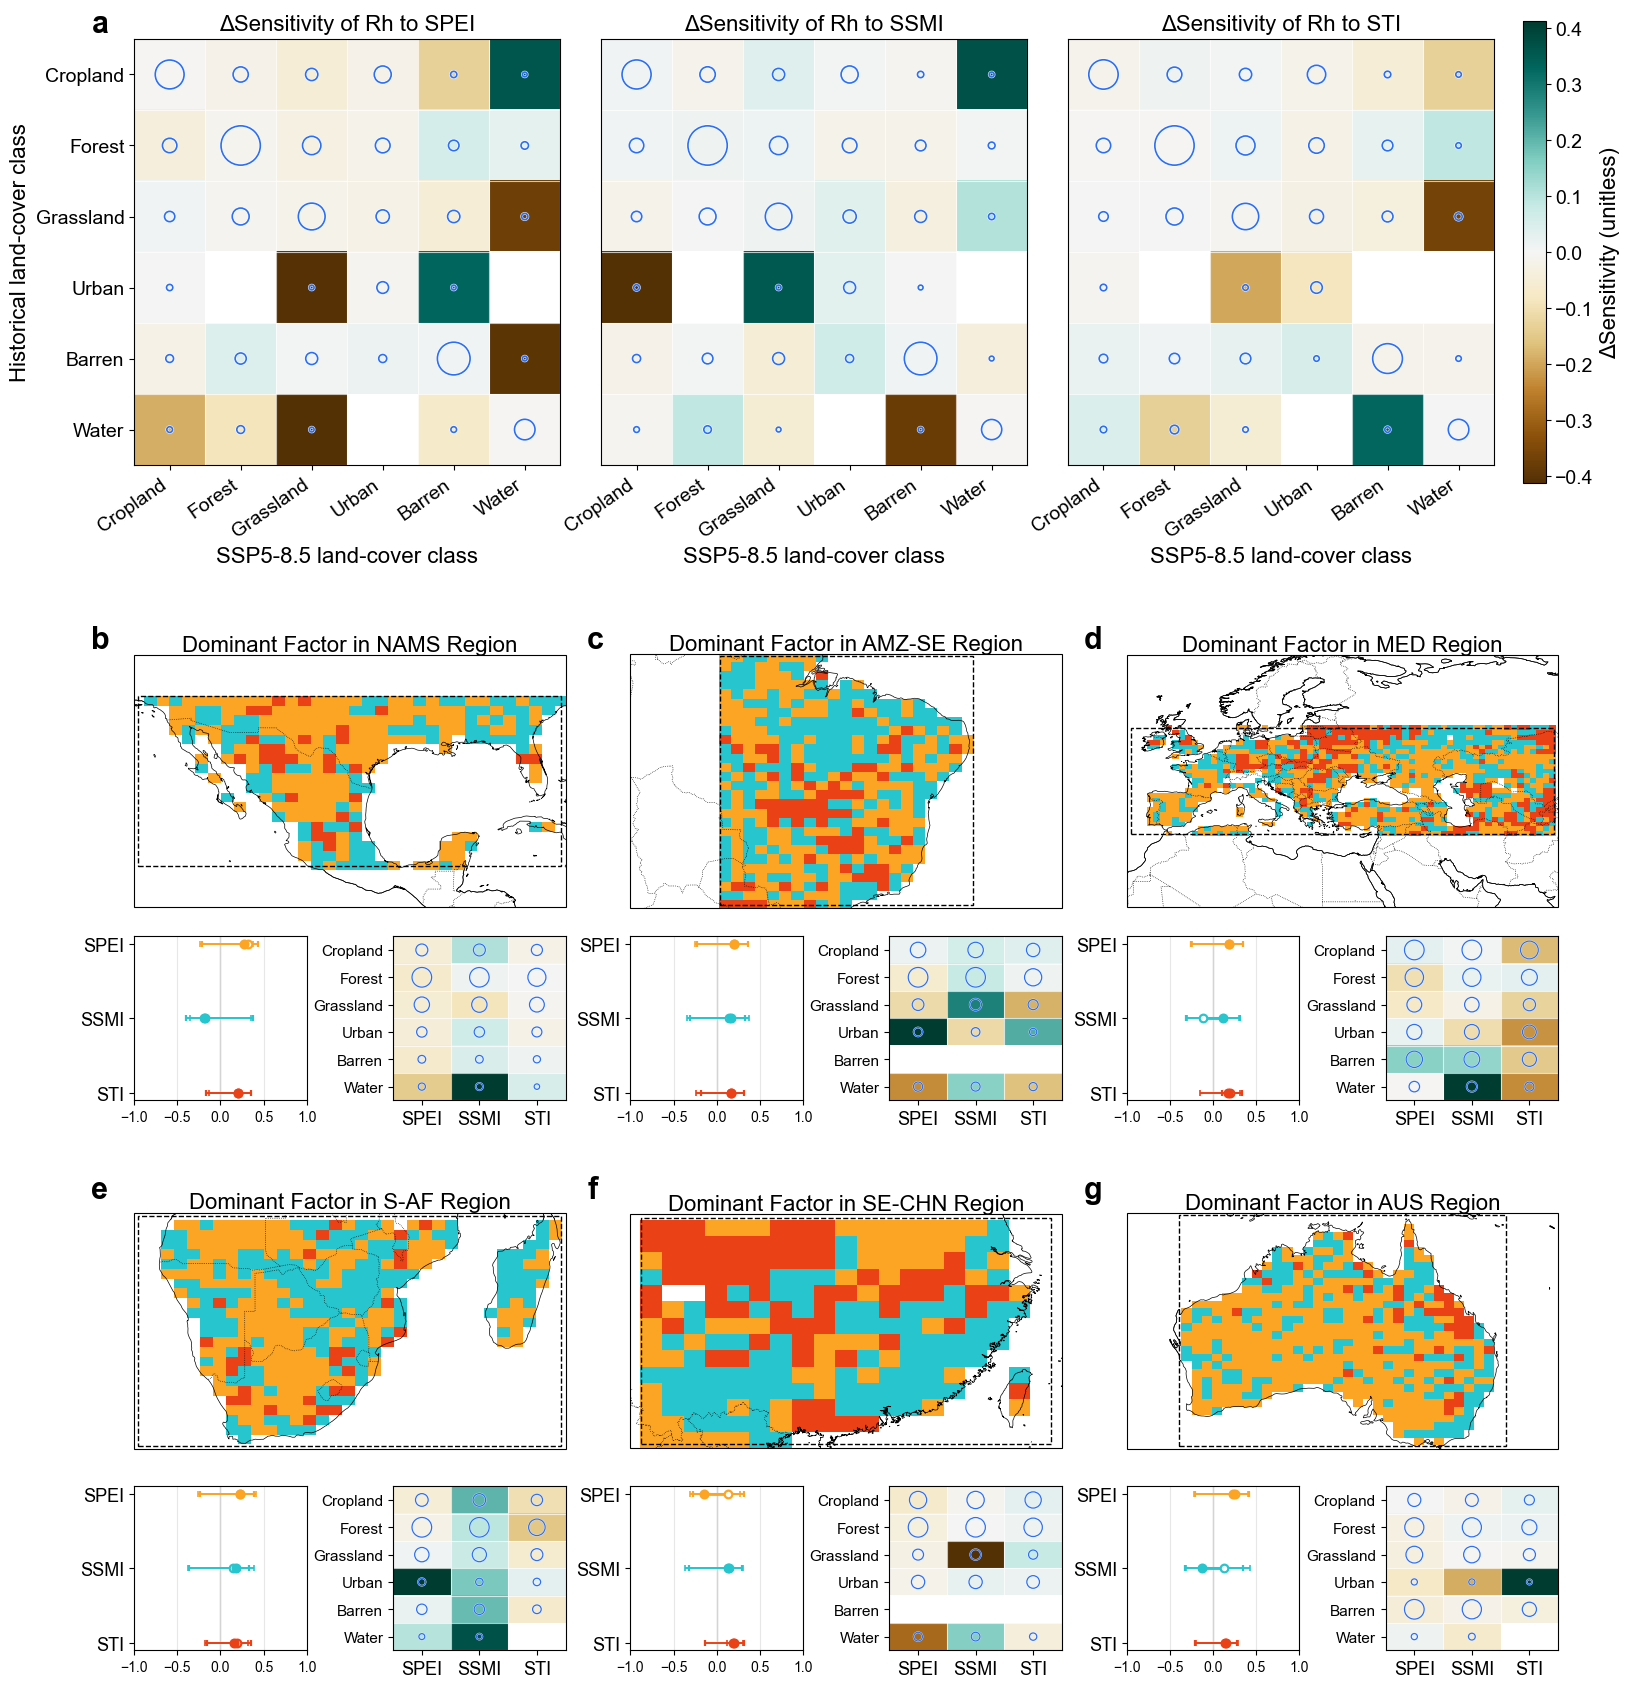

In [9]:
def create_extendedfigure8():
    # 重置matplotlib默认样式，避免全局设置干扰
    plt.rcParams.update(plt.rcParamsDefault)
    # 明确设置子图背景色和边框默认值
    plt.rcParams['axes.facecolor'] = 'white'       # 子图背景白色
    plt.rcParams['axes.edgecolor'] = 'black'       # 边框默认黑色
    plt.rcParams.update({
        'font.family': 'serif',           # 主字体类型（serif衬线 / sans-serif无衬线）
        'font.serif': ['Arial'], # 衬线字体首选
        'font.sans-serif': ['Times New Roman'],      # 无衬线字体备选
    })

    # 创建图形和子图布局
    fig = plt.figure(figsize=(16, 20))

    # 创建2x1的子图布局（根据实际需求调整）
    gs = gridspec.GridSpec(3, 3, figure=fig, height_ratios=[4, 3, 3], wspace=0.15, hspace=0.1, top=0.95, bottom=0.07, left=0.1, right=0.99)

    # 第一个子图（图4a）
    ax1 = fig.add_subplot(gs[0, :])
    mesh1 = plot_extendedfig6a(fig, ax1, 'ssp585', 'rh')

    # 第二个子图（图4b）
    ax2 = fig.add_subplot(gs[3], projection=ccrs.PlateCarree())
    mesh2 = plot_extendedfig6b(fig, ax2, 'ssp585', 'rh')

    # 第三个子图（图4c）
    ax3 = fig.add_subplot(gs[4], projection=ccrs.PlateCarree())
    mesh3 = plot_extendedfig6c(fig, ax3, 'ssp585', 'rh')

    # 第四个子图（图4d）
    ax4 = fig.add_subplot(gs[5], projection=ccrs.PlateCarree())
    mesh4 = plot_extendedfig6d(fig, ax4, 'ssp585', 'rh')

    # 第五个子图（图4e）
    ax5 = fig.add_subplot(gs[6], projection=ccrs.PlateCarree())
    mesh5 = plot_extendedfig6e(fig, ax5, 'ssp585', 'rh')

    # 第六个子图（图4f）
    ax6 = fig.add_subplot(gs[7], projection=ccrs.PlateCarree())
    mesh6 = plot_extendedfig6f(fig, ax6, 'ssp585', 'rh')

    # 第七个子图（图4g）
    ax7 = fig.add_subplot(gs[8], projection=ccrs.PlateCarree())
    mesh7 = plot_extendedfig6g(fig, ax7, 'ssp585', 'rh')

    plt.show()

if __name__ == '__main__':
    create_extendedfigure8()

C:\Users\73433\AppData\Local\Temp\ipykernel_35088\1702583426.py:142: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  im = ax.imshow(mat, origin='upper', cmap=cm.get_cmap("BrBG"), norm=norm,
C:\Users\73433\AppData\Local\Temp\ipykernel_35088\1702583426.py:184: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(classes, fontsize=16)
C:\Users\73433\AppData\Local\Temp\ipykernel_35088\1702583426.py:142: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  im = ax.imshow(mat, origin='upper', cmap=cm.get_cmap("BrBG"), norm=norm,
C:\Users\73433\AppData\Local\Temp\ipyk

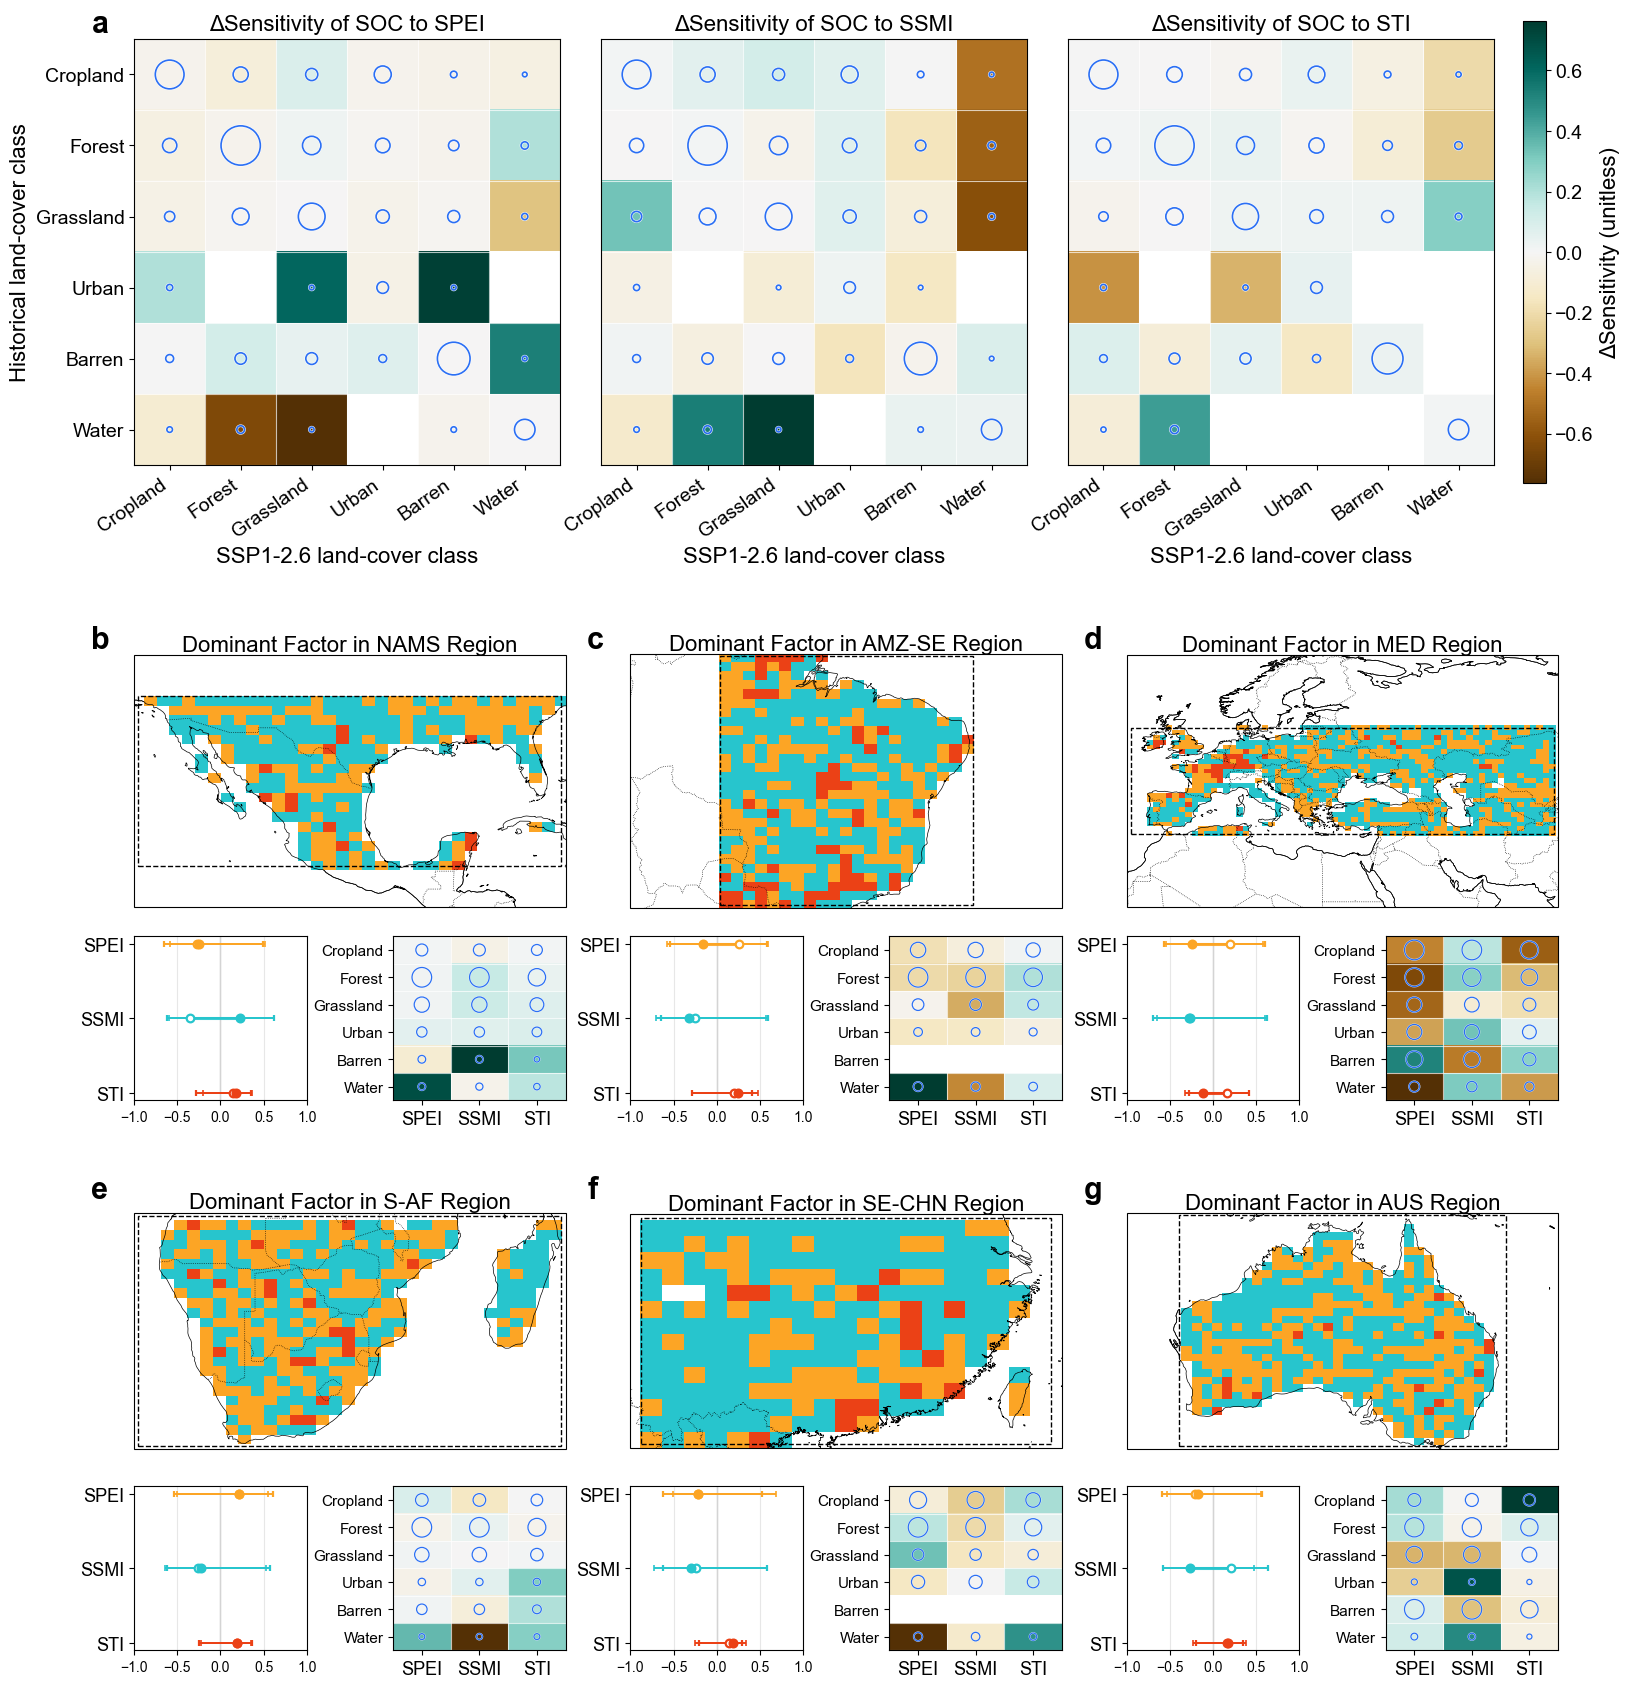

In [10]:
def create_extendedfigure9():
    # 重置matplotlib默认样式，避免全局设置干扰
    plt.rcParams.update(plt.rcParamsDefault)
    # 明确设置子图背景色和边框默认值
    plt.rcParams['axes.facecolor'] = 'white'       # 子图背景白色
    plt.rcParams['axes.edgecolor'] = 'black'       # 边框默认黑色
    plt.rcParams.update({
        'font.family': 'serif',           # 主字体类型（serif衬线 / sans-serif无衬线）
        'font.serif': ['Arial'], # 衬线字体首选
        'font.sans-serif': ['Times New Roman'],      # 无衬线字体备选
    })

    # 创建图形和子图布局
    fig = plt.figure(figsize=(16, 20))

    # 创建2x1的子图布局（根据实际需求调整）
    gs = gridspec.GridSpec(3, 3, figure=fig, height_ratios=[4, 3, 3], wspace=0.15, hspace=0.1, top=0.95, bottom=0.07, left=0.1, right=0.99)

    # 第一个子图（图4a）
    ax1 = fig.add_subplot(gs[0, :])
    mesh1 = plot_extendedfig6a(fig, ax1, 'ssp126', 'soc')

    # 第二个子图（图4b）
    ax2 = fig.add_subplot(gs[3], projection=ccrs.PlateCarree())
    mesh2 = plot_extendedfig6b(fig, ax2, 'ssp126', 'soc')

    # 第三个子图（图4c）
    ax3 = fig.add_subplot(gs[4], projection=ccrs.PlateCarree())
    mesh3 = plot_extendedfig6c(fig, ax3, 'ssp126', 'soc')

    # 第四个子图（图4d）
    ax4 = fig.add_subplot(gs[5], projection=ccrs.PlateCarree())
    mesh4 = plot_extendedfig6d(fig, ax4, 'ssp126', 'soc')

    # 第五个子图（图4e）
    ax5 = fig.add_subplot(gs[6], projection=ccrs.PlateCarree())
    mesh5 = plot_extendedfig6e(fig, ax5, 'ssp126', 'soc')

    # 第六个子图（图4f）
    ax6 = fig.add_subplot(gs[7], projection=ccrs.PlateCarree())
    mesh6 = plot_extendedfig6f(fig, ax6, 'ssp126', 'soc')

    # 第七个子图（图4g）
    ax7 = fig.add_subplot(gs[8], projection=ccrs.PlateCarree())
    mesh7 = plot_extendedfig6g(fig, ax7, 'ssp126', 'soc')

    plt.show()

if __name__ == '__main__':
    create_extendedfigure9()

C:\Users\73433\AppData\Local\Temp\ipykernel_35088\1702583426.py:142: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  im = ax.imshow(mat, origin='upper', cmap=cm.get_cmap("BrBG"), norm=norm,
C:\Users\73433\AppData\Local\Temp\ipykernel_35088\1702583426.py:184: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(classes, fontsize=16)
C:\Users\73433\AppData\Local\Temp\ipykernel_35088\1702583426.py:142: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  im = ax.imshow(mat, origin='upper', cmap=cm.get_cmap("BrBG"), norm=norm,
C:\Users\73433\AppData\Local\Temp\ipyk

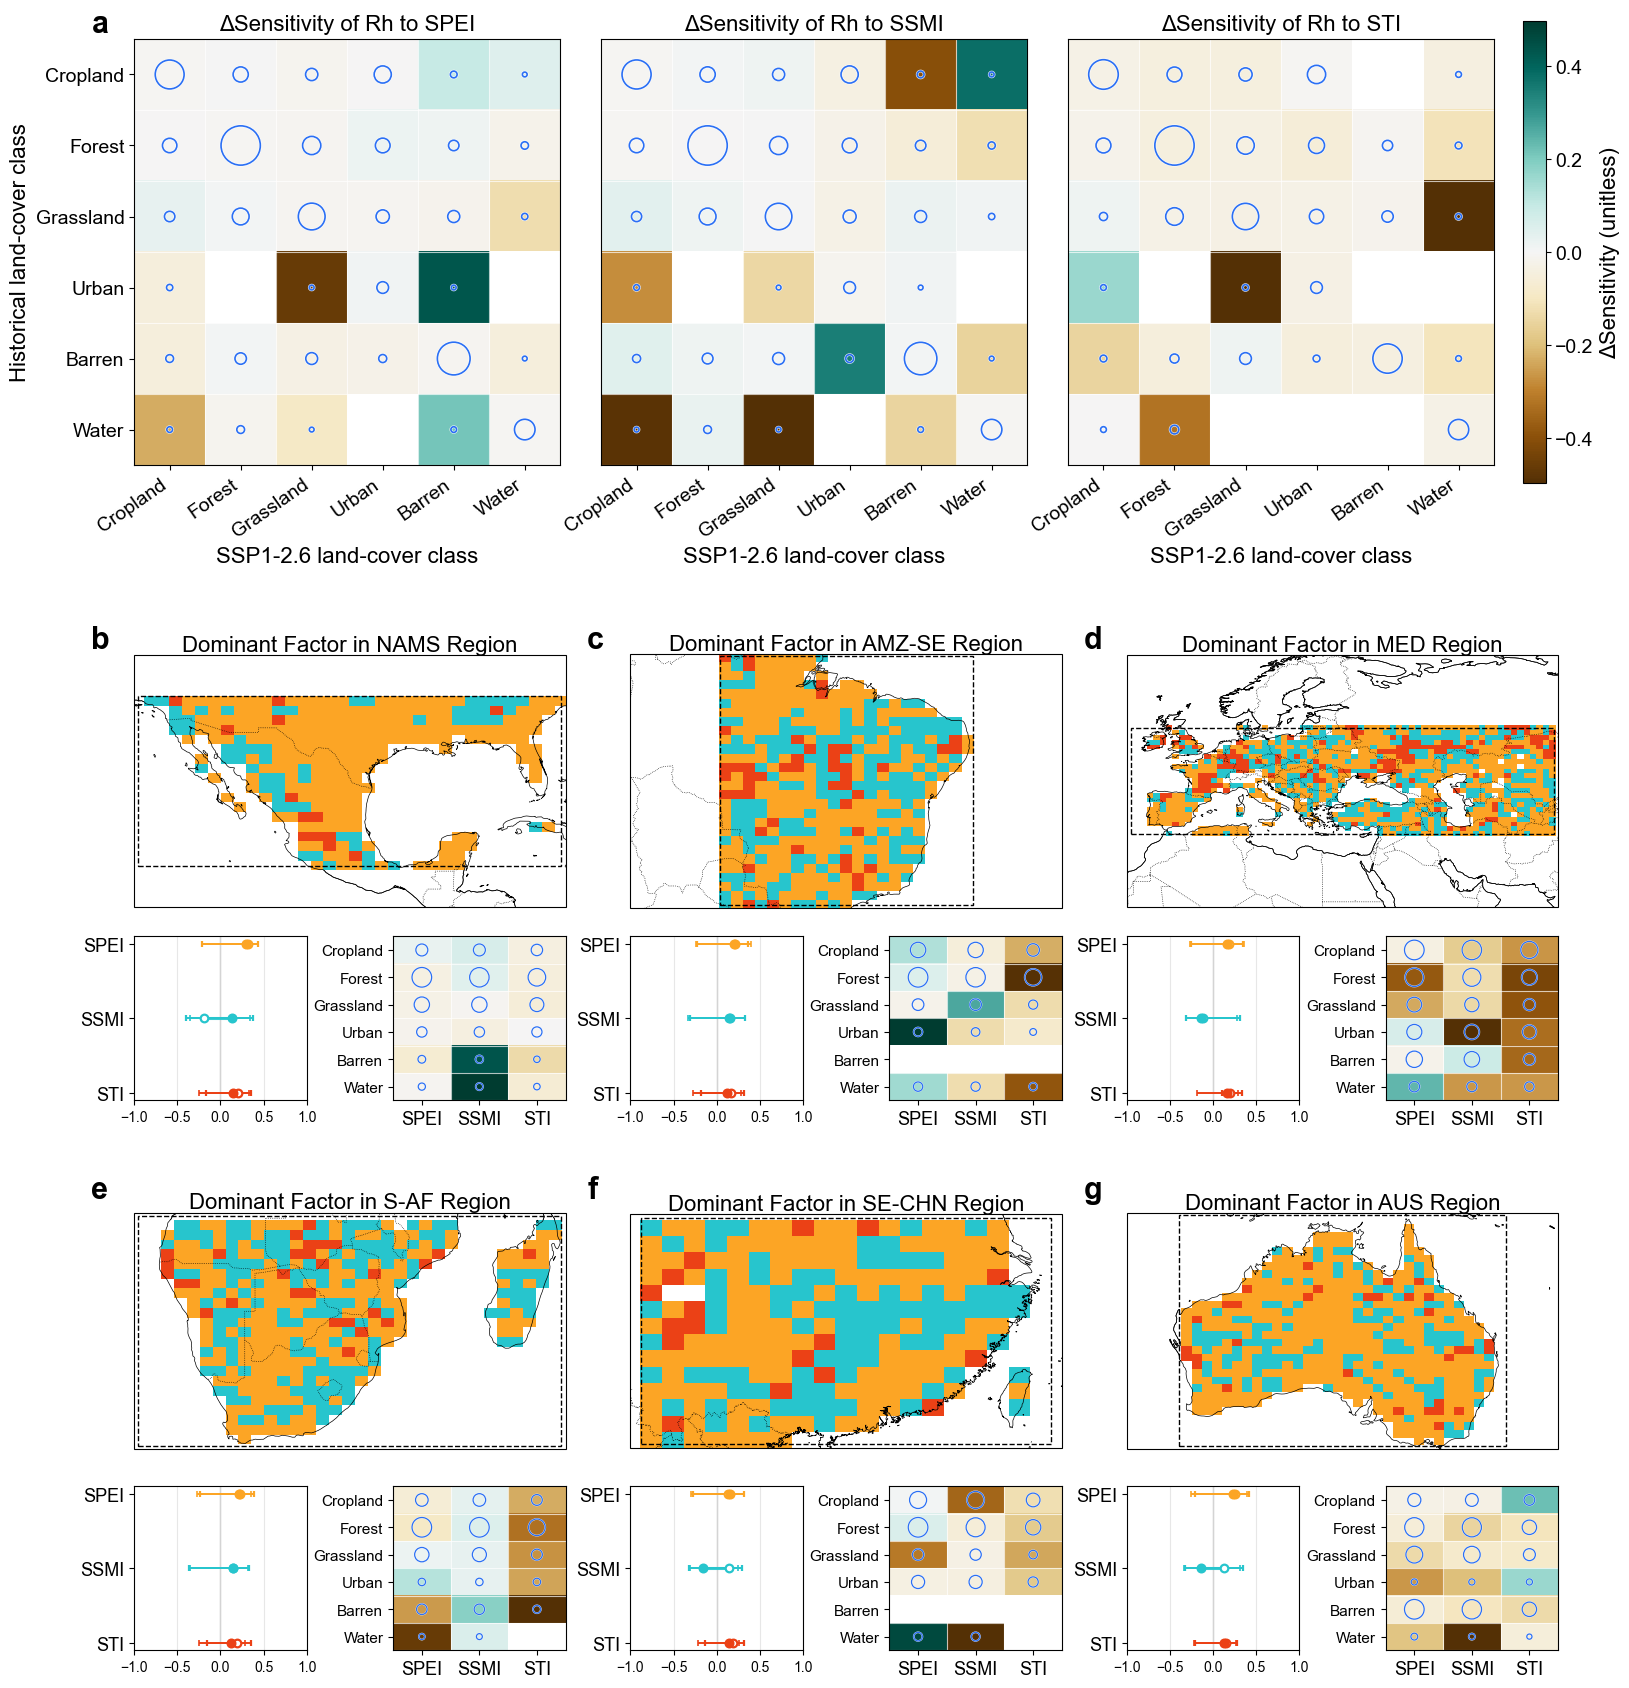

In [11]:
def create_extendedfigure10():
    # 重置matplotlib默认样式，避免全局设置干扰
    plt.rcParams.update(plt.rcParamsDefault)
    # 明确设置子图背景色和边框默认值
    plt.rcParams['axes.facecolor'] = 'white'       # 子图背景白色
    plt.rcParams['axes.edgecolor'] = 'black'       # 边框默认黑色
    plt.rcParams.update({
        'font.family': 'serif',           # 主字体类型（serif衬线 / sans-serif无衬线）
        'font.serif': ['Arial'], # 衬线字体首选
        'font.sans-serif': ['Times New Roman'],      # 无衬线字体备选
    })

    # 创建图形和子图布局
    fig = plt.figure(figsize=(16, 20))

    # 创建2x1的子图布局（根据实际需求调整）
    gs = gridspec.GridSpec(3, 3, figure=fig, height_ratios=[4, 3, 3], wspace=0.15, hspace=0.1, top=0.95, bottom=0.07, left=0.1, right=0.99)

    # 第一个子图（图4a）
    ax1 = fig.add_subplot(gs[0, :])
    mesh1 = plot_extendedfig6a(fig, ax1, 'ssp126', 'rh')

    # 第二个子图（图4b）
    ax2 = fig.add_subplot(gs[3], projection=ccrs.PlateCarree())
    mesh2 = plot_extendedfig6b(fig, ax2, 'ssp126', 'rh')

    # 第三个子图（图4c）
    ax3 = fig.add_subplot(gs[4], projection=ccrs.PlateCarree())
    mesh3 = plot_extendedfig6c(fig, ax3, 'ssp126', 'rh')

    # 第四个子图（图4d）
    ax4 = fig.add_subplot(gs[5], projection=ccrs.PlateCarree())
    mesh4 = plot_extendedfig6d(fig, ax4, 'ssp126', 'rh')

    # 第五个子图（图4e）
    ax5 = fig.add_subplot(gs[6], projection=ccrs.PlateCarree())
    mesh5 = plot_extendedfig6e(fig, ax5, 'ssp126', 'rh')

    # 第六个子图（图4f）
    ax6 = fig.add_subplot(gs[7], projection=ccrs.PlateCarree())
    mesh6 = plot_extendedfig6f(fig, ax6, 'ssp126', 'rh')

    # 第七个子图（图4g）
    ax7 = fig.add_subplot(gs[8], projection=ccrs.PlateCarree())
    mesh7 = plot_extendedfig6g(fig, ax7, 'ssp126', 'rh')

    plt.show()

if __name__ == '__main__':
    create_extendedfigure10()